In [1]:
import pandas as pd
from ast import literal_eval
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [2]:
ds_resumes = pd.read_csv('ds_resumes_scraped_1_23.csv')
ds_resumes['job_type'] = 'data scientist'
da_resumes = pd.read_csv('da_resumes_scraped_1_23.csv')
da_resumes['job_type'] = 'data analyst'
resumes = pd.concat([ds_resumes, da_resumes], ignore_index=True)

In [3]:
len(resumes)

1170

In [4]:
resumes.head()

,job_titles,job_durations,job_descriptions,degrees,schools,graduation_dates,job_type
0,"['Data Scientist', 'Business Inteligence Consu...","['February 2013 to Present', 'January 2006 to ...","['2016 ~ Manager, Smart Solution Team in Infor...","['Master in Business Administration', 'Bachelo...","['KAIST', 'Konkuk University']","['January 2012 to January 2013', 'March 1999 t...",data scientist
1,"['Director of Business Relations', 'Senior Dat...","['May 2018 to Present', 'May 2014 to July 2016']","[""GIMME360 Data Scientist-Business Solution ...","['Master in applied mathematics', 'Bachelor in...","['University of Waterloo', 'University of Wate...","['January 2016 to January 2018', 'January 2010...",data scientist
2,"['FREELANCE DEVELOPER', 'Data Scientist', 'DES...","['March 2016 to Present', 'April 2018 to Augus...","['Toronto, Canada• Completed 30+ freelancer Pr...",['BACHELORS in COMPUTER ENGINEERING'],['UNIVERSITY OF TORONTO'],['April 2021'],data scientist
3,"['Automation Test Engineer', 'Data Scientist',...","['December 2018 to Present', 'August 2018 to N...",['Responsibilities: ⚫ GM Infotainment syste...,['Master in Electrical and Computer Engineerin...,"['University of Ottawa', 'Beijing Institute of...","['September 2015 to June 2017', 'September 200...",data scientist
4,"['Validation Scientist Co-Op (PEY)', 'Data Col...","['September 2017 to August 2018', 'May 2015 to...",['• Developing qualification document for a ne...,['B.A.Sc in Electrical Engineering'],['University of Toronto'],['September 2014 to April 2019'],data scientist


In [5]:
columns = ['job_titles', 'job_durations', 'job_descriptions', 'degrees', 'schools', 'graduation_dates']
for col in columns:
    resumes[col] = resumes[col].apply(lambda x: literal_eval(x)) # pandas read columns as string, change back to list

In [6]:
resumes.head()

,job_titles,job_durations,job_descriptions,degrees,schools,graduation_dates,job_type
0,"[Data Scientist, Business Inteligence Consultant]","[February 2013 to Present, January 2006 to Feb...","[2016 ~ Manager, Smart Solution Team in Inform...","[Master in Business Administration, Bachelor o...","[KAIST, Konkuk University]","[January 2012 to January 2013, March 1999 to F...",data scientist
1,"[Director of Business Relations, Senior Data A...","[May 2018 to Present, May 2014 to July 2016]",[GIMME360 Data Scientist-Business Solution 2...,"[Master in applied mathematics, Bachelor in ap...","[University of Waterloo, University of Waterloo]","[January 2016 to January 2018, January 2010 to...",data scientist
2,"[FREELANCE DEVELOPER, Data Scientist, DESIGN E...","[March 2016 to Present, April 2018 to August 2...","[Toronto, Canada• Completed 30+ freelancer Pro...",[BACHELORS in COMPUTER ENGINEERING],[UNIVERSITY OF TORONTO],[April 2021],data scientist
3,"[Automation Test Engineer, Data Scientist, Dat...","[December 2018 to Present, August 2018 to Nove...",[Responsibilities: ⚫ GM Infotainment system...,[Master in Electrical and Computer Engineering...,"[University of Ottawa, Beijing Institute of Te...","[September 2015 to June 2017, September 2009 t...",data scientist
4,"[Validation Scientist Co-Op (PEY), Data Collec...","[September 2017 to August 2018, May 2015 to Se...",[• Developing qualification document for a new...,[B.A.Sc in Electrical Engineering],[University of Toronto],[September 2014 to April 2019],data scientist


In [7]:
resumes['resume_id'] = [i+1 for i in range(len(resumes))]
# have separate dfs for each column for easier data manipulation
titles = resumes[['resume_id', 'job_type', 'job_titles']]
durations = resumes[['resume_id', 'job_durations']]
descriptions = resumes[['resume_id', 'job_descriptions']]
degrees = resumes[['resume_id', 'job_type', 'degrees']]
schools = resumes[['resume_id', 'schools']]
graduation = resumes[['resume_id', 'graduation_dates']]

In [8]:
# split list into rows for job titles
titles = titles['job_titles'].apply(pd.Series) \
         .merge(titles, right_index=True, left_index=True) \
         .drop(['job_titles'], axis=1) \
         .melt(id_vars=['resume_id', 'job_type'], value_name="job_title")

In [9]:
# split list into rows for job durations
durations = durations['job_durations'].apply(pd.Series) \
         .merge(durations, right_index=True, left_index=True) \
         .drop(['job_durations'], axis=1) \
         .melt(id_vars=['resume_id'], value_name="job_duration")

In [10]:
# split list into rows for job descriptions
descriptions = descriptions['job_descriptions'].apply(pd.Series) \
         .merge(descriptions, right_index=True, left_index=True) \
         .drop(['job_descriptions'], axis=1) \
         .melt(id_vars=['resume_id'], value_name="job_description")

In [11]:
# merge all work exp variables
work_exp = titles.merge(durations, on=['resume_id', 'variable']) \
           .merge(descriptions, on=['resume_id', 'variable']) \
           .dropna()
work_exp.rename(columns={'variable':'job_id'}, inplace=True) # job_id: current job is 0 prev ones 1, 2...
work_exp = work_exp.sort_values(by=['resume_id', 'job_id'])
work_exp = work_exp.reset_index(drop=True)

In [12]:
work_exp.head()

,resume_id,job_type,job_id,job_title,job_duration,job_description
0,1,data scientist,0,Data Scientist,February 2013 to Present,"2016 ~ Manager, Smart Solution Team in Informa..."
1,1,data scientist,1,Business Inteligence Consultant,January 2006 to February 2013,2011 Social Media Analysis- Participate in the...
2,2,data scientist,0,Director of Business Relations,May 2018 to Present,GIMME360 Data Scientist-Business Solution 20...
3,2,data scientist,1,Senior Data Analyst-Customer Interaction Decis...,May 2014 to July 2016,SAS Fulltime• Translated business objectives ...
4,3,data scientist,0,FREELANCE DEVELOPER,March 2016 to Present,"Toronto, Canada• Completed 30+ freelancer Proj..."


In [13]:
# split list into rows for degrees
degrees = degrees['degrees'].apply(pd.Series) \
         .merge(degrees, right_index=True, left_index=True) \
         .drop(['degrees'], axis=1) \
         .melt(id_vars=['resume_id', 'job_type'], value_name="degree")

In [14]:
# split list into rows for schools
schools = schools['schools'].apply(pd.Series) \
         .merge(schools, right_index=True, left_index=True) \
         .drop(['schools'], axis=1) \
         .melt(id_vars=['resume_id'], value_name="school")

In [15]:
# split list into rows for graduation dats
graduation = graduation['graduation_dates'].apply(pd.Series) \
             .merge(graduation, right_index=True, left_index=True) \
             .drop(['graduation_dates'], axis=1) \
             .melt(id_vars=['resume_id'], value_name="graduation")

In [16]:
# merge all education related variables
education = degrees.merge(schools, on=['resume_id', 'variable']) \
            .merge(graduation, on=['resume_id', 'variable']) \
            .dropna()
education.rename(columns={'variable':'education_id'}, inplace=True) # education_id: most recent ed is 0 prev ones 1, 2...
education = education.sort_values(by=['resume_id'])
education = education.reset_index(drop=True)

In [17]:
education.head()

,resume_id,job_type,education_id,degree,school,graduation
0,1,data scientist,0,Master in Business Administration,KAIST,January 2012 to January 2013
1,1,data scientist,1,Bachelor of Engineering in Computer Engineering,Konkuk University,March 1999 to February 2004
2,2,data scientist,0,Master in applied mathematics,University of Waterloo,January 2016 to January 2018
3,2,data scientist,1,Bachelor in applied mathematics,University of Waterloo,January 2010 to January 2014
4,3,data scientist,0,BACHELORS in COMPUTER ENGINEERING,UNIVERSITY OF TORONTO,April 2021


In [18]:
# preparing for text preprocessing: tokenizer, stopwords, and lemmatizer
tokenizer = RegexpTokenizer(r'\w+')
stopwords_en = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [19]:
# text preprocessing: remove special characters, remove digits, tokenize, 
# lowercase, remove stopwords, lemmatize
def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text )
    text = re.sub(r'\s+', ' ', text)
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en]
    return ' '.join(tokens) # change from list to string

In [20]:
for col in ['job_title', 'job_description']:
    work_exp[col+'_processed'] = work_exp[col].apply(preprocess)

In [21]:
work_exp

,resume_id,job_type,job_id,job_title,job_duration,job_description,job_title_processed,job_description_processed
0,1,data scientist,0,Data Scientist,February 2013 to Present,"2016 ~ Manager, Smart Solution Team in Informa...",data scientist,manager smart solution team information planni...
1,1,data scientist,1,Business Inteligence Consultant,January 2006 to February 2013,2011 Social Media Analysis- Participate in the...,business inteligence consultant,social medium analysis participate development...
2,2,data scientist,0,Director of Business Relations,May 2018 to Present,GIMME360 Data Scientist-Business Solution 20...,director business relation,gimme data scientist business solution present...
3,2,data scientist,1,Senior Data Analyst-Customer Interaction Decis...,May 2014 to July 2016,SAS Fulltime• Translated business objectives ...,senior data analyst customer interaction decis...,sa fulltime translated business objective data...
4,3,data scientist,0,FREELANCE DEVELOPER,March 2016 to Present,"Toronto, Canada• Completed 30+ freelancer Proj...",freelance developer,toronto canada completed freelancer project in...
5,3,data scientist,1,Data Scientist,April 2018 to August 2018,"Toronto, Canada• Developed deep learning model...",data scientist,toronto canada developed deep learning model s...
6,3,data scientist,2,DESIGN ENGINEER,January 2018 to June 2018,"Toronto, Canada• Worked with a private client ...",design engineer,toronto canada worked private client design pr...
7,4,data scientist,0,Automation Test Engineer,December 2018 to Present,Responsibilities: ⚫ GM Infotainment system ...,automation test engineer,responsibility gm infotainment system verifica...
8,4,data scientist,1,Data Scientist,August 2018 to November 2018,Responsibilities: ⚫ Research and develop st...,data scientist,responsibility research develop statistical le...
9,4,data scientist,2,Data Science Engineer,September 2017 to August 2018,Responsibilities: ⚫ As site Hadoop Admin re...,data science engineer,responsibility site hadoop admin responsible m...


In [22]:
# definition for plotting n most common words in column with text
def plot_common_words(df, column, n):
    fdist = Counter(' '.join(row for row in df[column]).split()).most_common(n) # freq distribution of 20 most common words
    word = [i[0] for i in fdist]
    count = [i[1] for i in fdist]
    word_pos = [i for i, _ in enumerate(word)]
    
    plt.figure(figsize=(8, 6))
    plt.barh(word_pos, count)
    plt.yticks(word_pos, word)
    plt.ylabel('word')
    plt.xlabel('count')
    plt.title('Frequency of'+' '+str(n)+' '+'most common words in {}'.format(column))
    plt.gca().invert_yaxis() # invert y axis to descending order
    plt.show()

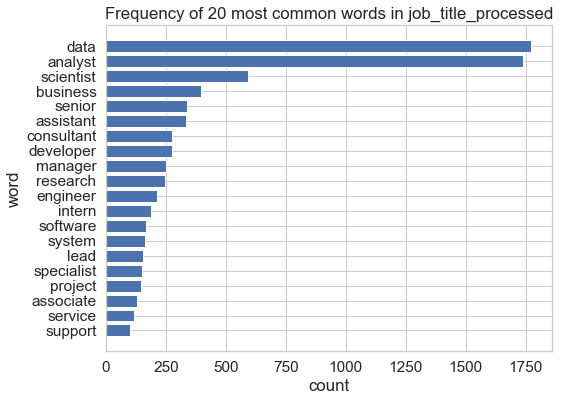

In [23]:
# plot most common words in job titles
sns.set(style='whitegrid', font_scale=1.4)
plot_common_words(work_exp, 'job_title_processed', 20) 

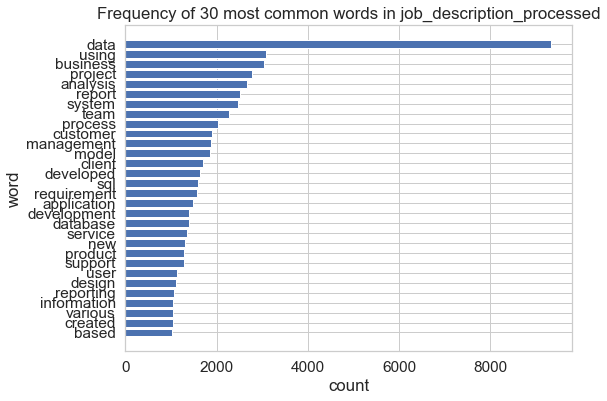

In [24]:
plot_common_words(work_exp, 'job_description_processed', 30)

In [25]:
# vectorize text in job description
vectorizer = TfidfVectorizer()
job_description_vec = vectorizer.fit_transform(work_exp.job_description_processed) 

In [26]:
vectorizer.get_feature_names()

['aa',
 'aaa',
 'aafc',
 'aai',
 'aalto',
 'aaltouniversity',
 'aat',
 'ab',
 'aba',
 'abadata',
 'abandon',
 'abandoned',
 'abandonment',
 'abanking',
 'abap',
 'abb',
 'abbey',
 'abbott',
 'abbreviation',
 'abdulkadir',
 'abdullah',
 'abend',
 'abends',
 'abengoa',
 'abet',
 'abia',
 'abide',
 'abided',
 'abilitiesconfident',
 'ability',
 'abilityenglish',
 'abilitysatellite',
 'abinitio',
 'ablation',
 'able',
 'ables',
 'ablett',
 'ablettshannon',
 'abm',
 'abmotivated',
 'abnavi',
 'abnor',
 'abnormal',
 'abnormality',
 'abort',
 'abr',
 'abrasive',
 'abreast',
 'abresponsibilities',
 'abridging',
 'abroad',
 'absence',
 'absenteeism',
 'absolute',
 'absolutely',
 'absoluterecord',
 'abstract',
 'abstracted',
 'abstracting',
 'abstraction',
 'abstractive',
 'abu',
 'abua',
 'abuja',
 'abuse',
 'abusive',
 'abutment',
 'ac',
 'aca',
 'academia',
 'academic',
 'academicservices',
 'academy',
 'acapabilities',
 'acbs',
 'accelerate',
 'accelerated',
 'accelerating',
 'acceleration',


In [27]:
# fit nmf model
num_topics = 10
nmf = NMF(n_components = num_topics, random_state=42, alpha=0.1)
nmf_features = nmf.fit_transform(job_description_vec)

In [28]:
nmf_features

array([[0.0021039 , 0.1184089 , 0.        , ..., 0.        , 0.03075284,
        0.        ],
       [0.03875747, 0.00053254, 0.01685901, ..., 0.        , 0.00571416,
        0.00457296],
       [0.01588907, 0.03194286, 0.1249589 , ..., 0.        , 0.        ,
        0.01809312],
       ...,
       [0.01697494, 0.0210922 , 0.00577662, ..., 0.        , 0.03792088,
        0.        ],
       [0.00293047, 0.03324043, 0.0462944 , ..., 0.00482536, 0.05317335,
        0.01830925],
       [0.        , 0.        , 0.04035117, ..., 0.        , 0.01041482,
        0.        ]])

In [29]:
nmf.components_.shape

(10, 19600)

In [30]:
nmf_features.shape

(5045, 10)

In [31]:
norm_features = normalize(nmf_features)

In [34]:
norm_features

array([[0.01628711, 0.91664859, 0.        , ..., 0.        , 0.23806951,
        0.        ],
       [0.617439  , 0.00848385, 0.2685782 , ..., 0.        , 0.09103135,
        0.07285116],
       [0.11033078, 0.22180527, 0.8676914 , ..., 0.        , 0.        ,
        0.12563524],
       ...,
       [0.25360041, 0.3151109 , 0.08630092, ..., 0.        , 0.56652626,
        0.        ],
       [0.03521026, 0.39939104, 0.5562372 , ..., 0.05797777, 0.63888928,
        0.21998958],
       [0.        , 0.        , 0.56679023, ..., 0.        , 0.14629114,
        0.        ]])

In [35]:
# definition for getting top words in each topic
def get_nmf_topics(model, n_top_words):
    features = vectorizer.get_feature_names()
    
    word_dict = {};
    # for each topic, get the largest weights, and save the corresponding words into the dictionary
    for i in range(num_topics):
        ids = nmf.components_[i].argsort()[-n_top_words:] 
        word_dict['Topic ' + '{:01d}'.format(i+1)] = [features[id] for id in reversed(ids)]
        # word_ids is ordered such that largest weight is the last item, reverse it to have it as first item
    return pd.DataFrame(word_dict);

In [36]:
get_nmf_topics(nmf, 10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,business,data,customer,model,server,client,report,test,student,risk
1,project,analysis,product,learning,sql,account,excel,testing,course,credit
2,requirement,source,sale,machine,application,information,using,case,research,financial
3,process,quality,marketing,using,database,ensure,reporting,defect,university,sa
4,team,etl,service,python,system,service,sql,software,project,model
5,solution,database,campaign,algorithm,developed,system,dashboard,requirement,teaching,market
6,development,warehouse,order,developed,oracle,support,created,functional,statistical,portfolio
7,system,visualization,strategy,regression,web,team,vba,user,science,management
8,stakeholder,collection,insight,based,window,management,analysis,plan,computer,card
9,management,big,segmentation,analysis,development,issue,tableau,script,assignment,analysis


In [37]:
# have a df for document topic matrix, merge with work_exp df
doc_topic_weights = pd.DataFrame(norm_features, columns=['Topic '+'{:01d}'.format(i+1) for i in range(0, 10)])
work_exp = pd.concat([work_exp, doc_topic_weights], axis=1, sort=False)

In [38]:
work_exp.head()

,resume_id,job_type,job_id,job_title,job_duration,job_description,job_title_processed,job_description_processed,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,1,data scientist,0,Data Scientist,February 2013 to Present,"2016 ~ Manager, Smart Solution Team in Informa...",data scientist,manager smart solution team information planni...,0.016287,0.916649,0.000000,0.318587,0.000000,0.036270,0.000000,0.000000,0.238070,0.000000
1,1,data scientist,1,Business Inteligence Consultant,January 2006 to February 2013,2011 Social Media Analysis- Participate in the...,business inteligence consultant,social medium analysis participate development...,0.617439,0.008484,0.268578,0.311720,0.127547,0.000000,0.647712,0.000000,0.091031,0.072851
2,2,data scientist,0,Director of Business Relations,May 2018 to Present,GIMME360 Data Scientist-Business Solution 20...,director business relation,gimme data scientist business solution present...,0.110331,0.221805,0.867691,0.319051,0.000000,0.000000,0.261082,0.000000,0.000000,0.125635
3,2,data scientist,1,Senior Data Analyst-Customer Interaction Decis...,May 2014 to July 2016,SAS Fulltime• Translated business objectives ...,senior data analyst customer interaction decis...,sa fulltime translated business objective data...,0.161417,0.084536,0.418822,0.851802,0.000000,0.108416,0.196242,0.095139,0.077458,0.022462
4,3,data scientist,0,FREELANCE DEVELOPER,March 2016 to Present,"Toronto, Canada• Completed 30+ freelancer Proj...",freelance developer,toronto canada completed freelancer project in...,0.004144,0.000000,0.058928,0.692624,0.695674,0.000000,0.000000,0.000000,0.178900,0.028539


In [39]:
description = 'Developed data mining applications to scrape data directly from html and plain text. Performed complex SQL queries to aggregate data from disparate sources. Generated databases that exceed - in terms of size and quality - those provided by commercial vendors, giving Odette Faculty a competitive advantage with respect to the originality of their research. Performed ad hod analysis (linear/logistic/multivariate regressions, survival analysis and classification. Communicated findings with visualizations produced using Python data visualization library matplotlib.'

In [40]:
print(description)

Developed data mining applications to scrape data directly from html and plain text. Performed complex SQL queries to aggregate data from disparate sources. Generated databases that exceed - in terms of size and quality - those provided by commercial vendors, giving Odette Faculty a competitive advantage with respect to the originality of their research. Performed ad hod analysis (linear/logistic/multivariate regressions, survival analysis and classification. Communicated findings with visualizations produced using Python data visualization library matplotlib.


In [41]:
preprocess(description)

'developed data mining application scrape data directly html plain text performed complex sql query aggregate data disparate source generated database exceed term size quality provided commercial vendor giving odette faculty competitive advantage respect originality research performed ad hod analysis linear logistic multivariate regression survival analysis classification communicated finding visualization produced using python data visualization library matplotlib'

In [89]:
# function to recommend next job - doesn't work now
def recommend_next_job(description):
    text = preprocess(description)
    text_vec = vectorizer.transform([text])

    text_nmf = normalize(nmf.transform(text_vec))

    # calculate cosine similarity between input description and training descriptions
    cos_sim = norm_features.dot(text_nmf.T)
    cos_sim_df = pd.DataFrame(cos_sim, columns=['cos_sim'])
    # index of job with highest cosine similarity with input description
    index = cos_sim_df.sort_values(ascending=False, by=['cos_sim']).index[0]

    job_id = work_exp.loc[[index]]['job_id']
    if job_id != 0:
        resume_id = work_exp.loc[[index]]['resume_id']
        title = work_exp.loc[(work_exp.resume_id == resume_id) & (work_exp.job_id == job_id+1)]['job_title']
        return title

In [90]:
recommend_next_job(description)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [83]:
work_exp.loc[[4310]]['job_id'] != 0

4310    True
Name: job_id, dtype: bool

In [84]:
work_exp.loc[[4310]]['resume_id']

4310    1027
Name: resume_id, dtype: int64

In [88]:
work_exp.loc[(work_exp.resume_id == 1027) & (work_exp.job_id == 2)]['job_title']

4309    Chargée d'Etudes statistiques
Name: job_title, dtype: object

In [86]:
cos_sim_df.sort_values(ascending=False, by=['cos_sim']).index[1]

1570

In [64]:
cos_df

,0
0,0.904924
1,0.382924
2,0.405878
3,0.563472
4,0.531807
5,0.611471
6,0.348843
7,0.102870
8,0.587305
9,0.696512


In [60]:
cos_sim.sort_values(ascending=False)

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

In [49]:
text_nmf

array([[0.        , 0.77276406, 0.        , 0.501314  , 0.22423039,
        0.        , 0.27036443, 0.05646363, 0.15482422, 0.03138635]])